In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import wooldridge
from see import see
from py4etrics.truncreg import Truncreg
from py4etrics.tobit import Tobit
from py4etrics.heckit import Heckit
from py4etrics.hetero_test import het_test_probit

In [2]:
# 標本の大きさ 
n = 100

# y*を決定するx
x = np.sort(norm.rvs(0,3,size=n))  # ランダム変数を生成し昇順に並べる

# 被説明変数
y = 1 + x + norm.rvs(0,3,size=n)

# DataFrame
df = pd.DataFrame({'Y':y, 'Y_trunc':y, 'X':x})

# 閾値
left = 0

# 切断データの作成
cond = (df.loc[:,'Y'] <= left)
df.loc[cond,'Y_trunc'] = np.nan

# 切断された被説明変数
y_trunc = df['Y_trunc']

In [3]:
formula_full = 'Y ~ X'

result_full=  ols(formula_full, data=df).fit()

b0_full,b1_full = result_full.params

result_full.params

Intercept    0.886711
X            1.061132
dtype: float64

In [4]:
formula_trunc = 'Y_trunc ~ X'

result_trunc = ols(formula_trunc, data=df).fit()

b0_trunc, b1_trunc = result_trunc.params

result_trunc.params

Intercept    3.092501
X            0.573050
dtype: float64

In [5]:
x_trunc = df.dropna(subset=['Y_trunc']).loc[:,'X']  # 説明（１）
x_min = min(x_trunc)  # 説明（２）
x_max = max(x_trunc)  # 説明（３）

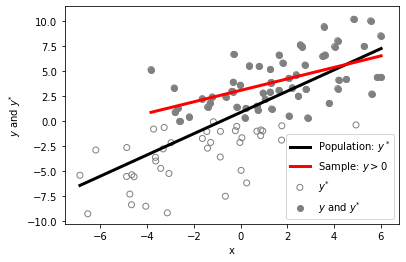

In [6]:
# （１）母集団データの散布図
plt.scatter(x, y, facecolors='none', edgecolors='gray',label=r'$y^{*}$')

# （２）切断データの散布図
plt.scatter(x, y_trunc, facecolors='gray', label=r'$y$ and $y^{*}$')

# 母集団OLS
plt.plot(x, b0_full+b1_full*x, 'k', linewidth=3, label='Population: $y^*$')

# 切断回帰
plt.plot(x_trunc, b0_trunc+b1_trunc*x_trunc, 'r', lw=3,label=r'Sample: $y> 0$')

plt.xlabel('x')
plt.ylabel(r'$y$ and $y^{*}$')
plt.legend()
pass

In [7]:
htv = wooldridge.data('HTV')
wooldridge.data('HTV',description=True)

name of dataset: htv
no of variables: 23
no of observations: 1230

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| wage     | hourly wage, 1991               |
| abil     | abil. measure, not standardized |
| educ     | highest grade completed by 1991 |
| ne       | =1 if in northeast, 1991        |
| nc       | =1 if in nrthcntrl, 1991        |
| west     | =1 if in west, 1991             |
| south    | =1 if in south, 1991            |
| exper    | potential experience            |
| motheduc | highest grade, mother           |
| fatheduc | highest grade, father           |
| brkhme14 | =1 if broken home, age 14       |
| sibs     | number of siblings              |
| urban    | =1 if in urban area, 1991       |
| ne18     | =1 if in NE, age 18             |
| nc18     | =1 if in NC, age 18             |
| south18  | =1 if in south, age 18          |
| west18   | =1 if in west, age 18      

In [8]:
formula_trunc = 'lwage ~ 1 + educ + abil + exper + nc + west + south + urban'

res_ols = ols(formula_trunc, data=htv).fit()

print(res_ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3987      0.185      2.158      0.031       0.036       0.761
educ           0.1037      0.010     10.704      0.000       0.085       0.123
abil           0.0558      0.008      6.565      0.000       0.039       0.072
exper          0.0448      0.007      6.619      0.000       0.032       0.058
nc            -0.1397      0.041     -3.440      0.001      -0.219      -0.060
west          -0.1282      0.049     -2.638      0.008      -0.224      -0.033
south         -0.1227      0.045     -2.742      0.006      -0.210      -0.035
urban          0.2268      0.041      5.589      0.000       0.147       0.306


In [9]:
htv_20 = htv.query('wage < 20')  # データの抽出

print(f'切断前の標本数：{len(htv)}')
print(f'切断前の標本数：{len(htv_20)}')
print(f'削除された標本数：{len(htv)-len(htv_20)}')

切断前の標本数：1230
切断前の標本数：1066
削除された標本数：164


In [10]:
res_ols_20 = ols(formula_trunc,data=htv_20).fit()

print(res_ols_20.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1795      0.174      6.795      0.000       0.839       1.520
educ           0.0579      0.009      6.258      0.000       0.040       0.076
abil           0.0548      0.008      7.168      0.000       0.040       0.070
exper          0.0218      0.006      3.467      0.001       0.009       0.034
nc            -0.1373      0.038     -3.644      0.000      -0.211      -0.063
west          -0.1415      0.045     -3.120      0.002      -0.230      -0.053
south         -0.1176      0.042     -2.833      0.005      -0.199      -0.036
urban          0.1653      0.037      4.525      0.000       0.094       0.237


In [11]:
res_trunc = Truncreg.from_formula(formula_trunc,right=np.log(20),data=htv_20).fit()

print(res_trunc.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.481943
         Iterations: 1216
         Function evaluations: 1715


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6094      0.302      2.018      0.044       0.017       1.201
educ           0.1060      0.017      6.312      0.000       0.073       0.139
abil           0.0818      0.013      6.448      0.000       0.057       0.107
exper          0.0356      0.011      3.309      0.001       0.015       0.057
nc            -0.2552      0.068     -3.734      0.000      -0.389      -0.121
west          -0.2652      0.081     -3.268      0.001      -0.424      -0.106
south         -0.2078      0.074     -2.818      0.005      -0.352      -0.063
urban          0.2657      0.059      4.478      0.000       0.149       0.382
Log(Sigma)    -0.5433      0.039    -14.053      0.000      -0.619      -0.468


In [12]:

see(res_trunc)

    <                <=               ==               !=               >
    >=               dir()            hash()           help()           repr()
    str()            .aic             .bic             .bootstrap()     .bse
    .bsejac          .bsejhj          .conf_int()      .cov_kwds
    .cov_params()    .cov_type        .covjac          .covjhj
    .df_model        .df_modelwc      .df_resid        .endog           .exog
    .f_test()        .fitted_endog    .fittedvalues    .get_nlfun()     .hessv
    .initialize()    .k_constant      .llf             .llnull          .llr
    .llr_pvalue      .load()          .mle_retvals     .mle_settings    .model
    .nobs            .normalized_cov_params            .params
    .predict()       .prsquared       .pvalues         .remove_data()
    .resid           .result_null     .save()          .scale
    .score_obsv      .set_null_options()               .summary()
    .t_test()        .t_test_pairwise()                .tvalues     

In [13]:
res_trunc.llf

-513.7517026401044

In [14]:
res_trunc.prsquared

0.17120380433327054

In [15]:
print(res_trunc.result_null.summary())

                         Truncreg Regression Results                          
Dep. Variable:                      y   Pseudo R-squ:                    0.000
Model:                       Truncreg   Log-Likelihood:                 -619.9
Method:            Maximum Likelihood   LL-Null:                        -619.9
Date:                Sat, 11 Jul 2020   LL-Ratio:                         -0.0
Time:                        21:21:54   LLR p-value:                       nan
No. Observations:                1066   AIC:                            1241.8
Df Residuals:                    1065   BIC:                            1246.7
Df Model:                           0   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6140      0.058     44.907      0.000       2.500       2.728
Log(Sigma)    -0.3590      0.047     -7.677      0.0

In [16]:
slopes_all = res_trunc.model.exog_names[1:-1]

In [17]:
# Wald検定
res_trunc.wald_test(slopes_all).summary()

'<Wald test (chi2): statistic=[[173.22132354]], p-value=5.2527918385346595e-34, df_denom=7>'

In [18]:
res_trunc.wald_test_all_slopes

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[173.22132354]], p-value=5.2527918385346595e-34, df_denom=7>

In [19]:
res_trunc.wald_test('educ+abil=exper').summary()

'<Wald test (chi2): statistic=[[130.94605426]], p-value=2.5442742489600915e-30, df_denom=1>'

In [20]:
y_hat = res_trunc.fittedvalues

print(f'最小値：{y_hat.min()}\n平均：{y_hat.mean()}\n最大値：{y_hat.max()}')

最小値：1.436527316538625
平均：2.5085741631765845
最大値：3.5561856163374266


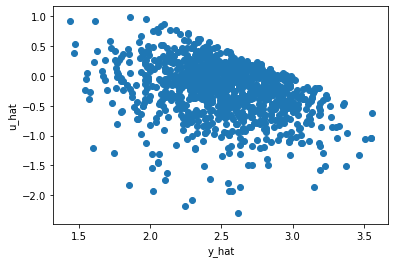

In [21]:
u_hat = res_trunc.resid
plt.scatter(y_hat,u_hat)
plt.xlabel('y_hat')
plt.ylabel('u_hat')
pass

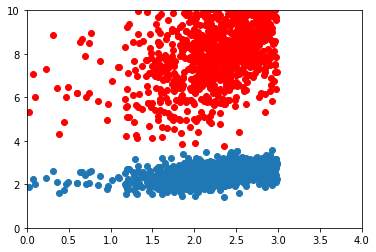

In [22]:
from scipy.stats import truncnorm
plt.scatter(htv_20['lwage'],y_hat)
plt.ylim(0,10)
plt.xlim(0,4)

X = res_trunc.fittedvalues
s = res_trunc.params[-1]
right = (np.log(20) - X)/np.exp(s)
imr = truncnorm.logpdf(-X/np.exp(s),a=-np.inf,b=right)
yexp = X-np.exp(s)*imr
plt.plot(htv_20['lwage'],yexp,'or')
# norm.cdf(X, loc=l, scale=s)

In [23]:
# 通常の標準偏差
tr0 = res_trunc.bse

# 不均一分散頑健標準編
tr1 = Truncreg.from_formula(formula_trunc,right=np.log(20),
                            data=htv_20).fit(cov_type='HC1',disp=False).bse

# 不均一分散頑健標準編を使った場合の標準偏差の変化率（％）
(100*(tr1-tr0)/tr0)[:-1]   # 最後は Log(Sigma) なので省く

array([ 1.31488659,  6.1496005 ,  2.31798789, -0.29282128, -1.99745692,
        3.82073133, -3.0276511 ,  2.77569811])

In [24]:
# データの大きさ 
n = 100

# y*を決定するx
x = np.sort(norm.rvs(0,3,size=n))  # ランダム変数を生成し昇順に並べる

# y*を生成
y_star = x + norm.rvs(0,3,size=n)

# yを生成
y = y_star.copy()  #  copy()はコピーを作るメソッド
y[y_star < 0] = 0  # y_star<0の場合，０を代入する

# DataFrame
df = pd.DataFrame({'Y':y, 'Y_star':y_star, 'X':x})

In [25]:
formula_star = 'Y_star ~ X'

result_star= ols(formula_star, data=df).fit()

b0_star,b1_star = result_star.params

print(result_star.params)

Intercept   -0.389296
X            1.221744
dtype: float64


In [26]:
formula_sample = 'Y ~ X'

result_corner = ols(formula_sample, data=df).fit()

b0_corner, b1_corner = result_corner.params

print(result_corner.params)

Intercept    1.570208
X            0.551958
dtype: float64


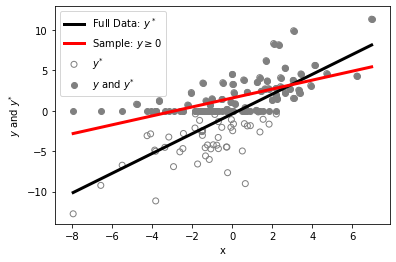

In [27]:
# y_starの散布図
plt.scatter(x, y_star, facecolors='none', edgecolors='gray',label=r'$y^{*}$')

# yの散布図
plt.scatter(x, y, facecolors='gray', label=r'$y$ and $y^{*}$')

# 母集団OLS
plt.plot(x, b0_star+b1_star*x, 'k', linewidth=3, label='Full Data: $y^*$')

# y>=0のOLS
plt.plot(x, b0_corner+b1_corner*x, 'r', lw=3,label=r'Sample: $y\geq 0$')

plt.xlabel('x')
plt.ylabel(r'$y$ and $y^{*}$')
plt.legend()
pass

In [28]:
mroz = wooldridge.data('mroz')

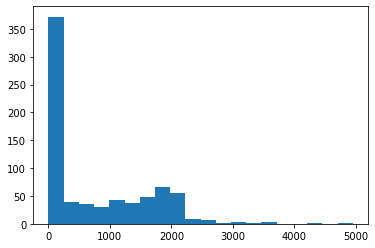

In [29]:
plt.hist(mroz['hours'],bins=20)
pass

In [30]:
left = 0

In [31]:
cond = (mroz['hours'] == left)  #  フィルターの作成

censor = np.zeros((len(mroz)))  # 0のarrayの作成

censor[cond] = -1  #  条件に合わせて-1を代入

pd.Series(censor).value_counts()  # Serieに変換し，内訳の確認

 0.0    428
-1.0    325
dtype: int64

In [32]:
censor = mroz['hours'].apply(lambda x: -1 if x==left else 0)

In [33]:
formula = 'hours ~ 1 + nwifeinc + educ + exper + expersq + age + kidslt6 + kidsge6'

res_tobit = Tobit.from_formula(formula,cens=censor,left=0,data=mroz).fit()

print(res_tobit.summary())

Optimization terminated successfully.
         Current function value: 5.071839
         Iterations: 2497
         Function evaluations: 3625


                              Tobit Regression Results                             
Dep. Variable:                       hours   Pseudo R-squ:                    0.034
Method:                 Maximum Likelihood   Log-Likelihood:                -3819.1
No. Observations:                      753   LL-Null:                       -3954.9
No. Uncensored Obs:                    428   LL-Ratio:                        271.6
No. Left-censored Obs:                 325   LLR p-value:                     0.000
No. Right-censored Obs:                  0   AIC:                            7654.2
Df Residuals:                          745   BIC:                            7691.2
Df Model:                                7   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    965.3054    446.431      2.162      0.031      90.317    1840.294
nwifein

In [34]:
see(res_tobit)

    <                <=               ==               !=               >
    >=               dir()            hash()           help()           repr()
    str()            .aic             .bic             .bootstrap()     .bse
    .bsejac          .bsejhj          .conf_int()      .cov_kwds
    .cov_params()    .cov_type        .covjac          .covjhj
    .df_model        .df_modelwc      .df_resid        .endog           .exog
    .f_test()        .fitted_endog    .fittedvalues    .get_nlfun()     .hessv
    .initialize()    .k_constant      .llf             .llnull          .llr
    .llr_pvalue      .load()          .mle_retvals     .mle_settings    .model
    .nobs            .normalized_cov_params            .obs
    .params          .predict()       .prsquared       .pvalues
    .remove_data()                    .resid           .result_null
    .save()          .scale           .score_obsv      .set_null_options()
    .summary()       .t_test()        .t_test_pairwise()
    .

In [35]:
res_tobit.wald_test('exper=expersq=0, kidslt6=kidsge6').summary()

'<Wald test (chi2): statistic=[[199.25002226]], p-value=6.126467400235263e-43, df_denom=3>'

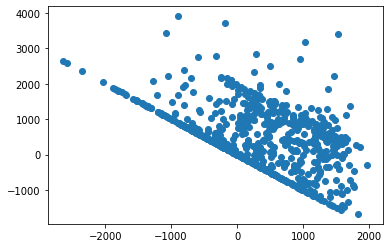

In [36]:
y_star_hat = res_tobit.fittedvalues

u_hat = res_tobit.resid

plt.scatter(y_star_hat,u_hat)
pass

In [37]:
# 通常の標準偏差
to0 = res_tobit.bse

# 不均一分散標準偏差
res_tobit_HC1 = Tobit.from_formula(formula,cens=censor,left=left,
                         data=mroz).fit(cov_type='HC1',disp=False)
to1 = res_tobit_HC1.bse

# 不均一分算標準偏差を使った場合の標準偏差の変化（％）
(100*(to1-to0)/to0)[:-1]     # Log(Sigma)を省く

array([ 0.37107505,  1.4553746 ,  1.12856511,  7.83246523,  6.92968004,
       -3.52866329,  4.88517743,  1.92156176])

In [38]:
mroz.query('inlf == 1')['lwage'].isna().sum()

0

In [39]:
( ~mroz.query('inlf == 0')['lwage'].isnull() ).sum()

0

In [40]:
# ステップ２：　mros

# ステップ３：第２段階の被説明変数
endog = mroz.loc[:,'lwage']

# ステップ４：第２段階の説明変数
exog = mroz.loc[:,['educ', 'exper', 'expersq']]
exog['Intercept'] = 1.0


# ステップ５：第１段階の説明変数
exog_select = mroz.loc[:,['educ', 'exper', 'expersq','nwifeinc', 'age', 'kidslt6', 'kidsge6', ]]
exog_select['Intercept'] = 1.0

In [41]:
res_heckit = Heckit(endog, exog, exog_select).fit(cov_type_2='HC1')

print(res_heckit.summary())

                           Heckit Regression Results                            
Dep. Variable:                    lwage   R-squared:                       0.156
Model:                           Heckit   Adj. R-squared:                  0.150
Method:                Heckman Two-Step   F-statistics:                   26.148
Date:                  Sat, 11 Jul 2020   Prob (F-statistic):              0.000
Time:                          21:22:21   Cov in 1st Stage:            nonrobust
No. Total Obs.:                     753   Cov in 2nd Stage:                  HC1
No. Censored Obs.:                  325                                         
No. Uncensored Obs.:                428                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
educ           0.1091      0.016      7.026      0.000       0.079       0.139
exper          0.0439      0.016  

In [42]:
see(res_heckit)

    <                  <=                 ==                 !=
    >                  >=                 dir()              hash()
    help()             repr()             str()              .HC1_se
    .bse               .centered_tss      .conf_int()        .corr_eqnerrors
    .cov_HC1           .cov_params()      .cov_type_1        .cov_type_2
    .df_model          .df_resid          .endog             .ess
    .exog              .f_pvalue          .f_test()          .fittedvalues
    .fvalue            .initialize()      .k_constant        .llf?
    .load()            .method            .model             .mse_model
    .mse_resid         .mse_total         .nobs
    .normalized_cov_params                .params
    .params_inverse_mills                 .pinv_wexog        .predict()
    .pvalues           .remove_data()     .resid             .rsquared
    .rsquared_adj      .save()            .scale             .select_res
    .ssr               .stderr_inverse_mills           

In [43]:
see(res_heckit.select_res)

    <                  <=                 ==                 !=
    >                  >=                 dir()              hash()
    help()             repr()             str()              .aic
    .bic               .bse               .conf_int()        .cov_kwds
    .cov_params()      .cov_type          .df_model          .df_resid
    .f_test()          .fittedvalues      .get_margeff()     .initialize()
    .k_constant        .llf               .llnull            .llr
    .llr_pvalue        .load()            .mle_retvals       .mle_settings
    .model             .nobs              .normalized_cov_params
    .params            .pred_table()      .predict()         .prsquared
    .pvalues           .remove_data()     .resid_dev
    .resid_generalized                    .resid_pearson     .resid_response
    .save()            .scale             .set_null_options()
    .summary()         .summary2()        .t_test()
    .t_test_pairwise()                    .tvalues           .u

In [44]:
print(res_heckit.select_res.summary().tables[0])

                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  753
Model:                         Probit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Sat, 11 Jul 2020   Pseudo R-squ.:                  0.2206
Time:                        21:22:21   Log-Likelihood:                -401.30
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 2.009e-45


In [45]:
formula = 'lwage ~ educ + exper + expersq'

res = ols(formula, data=mroz).fit(cov_type='HC1')

print(res.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5220      0.202     -2.589      0.010      -0.917      -0.127
educ           0.1075      0.013      8.131      0.000       0.082       0.133
exper          0.0416      0.015      2.722      0.006       0.012       0.072
expersq       -0.0008      0.000     -1.931      0.053      -0.002    1.21e-05


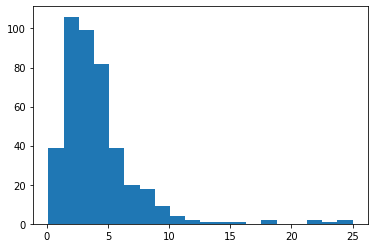

In [46]:
plt.hist(mroz['wage'].dropna(),bins=20)
pass

In [47]:
thresh = np.log(mroz['wage'].min()*0.5)  # 左切断の下限

formula = 'lwage ~ 1 + educ + exper + expersq'

res_trunc = Truncreg.from_formula(formula, left=thresh,
                                  data=mroz.dropna(subset=['lwage'])).fit()

print(res.summary().tables[1])

Optimization terminated successfully.
         Current function value: 1.008409
         Iterations: 68
         Function evaluations: 122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5220      0.202     -2.589      0.010      -0.917      -0.127
educ           0.1075      0.013      8.131      0.000       0.082       0.133
exper          0.0416      0.015      2.722      0.006       0.012       0.072
expersq       -0.0008      0.000     -1.931      0.053      -0.002    1.21e-05


In [48]:
het_test_probit(res_heckit.select_res)

H0: homoscedasticity
HA: heteroscedasticity
 
Wald test: 8.665 
p-value:   0.278 
df freedom:  7.
